In [ ]:
# placeholder so Colab can open this notebook


Rows, Columns: (569, 33)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_wors

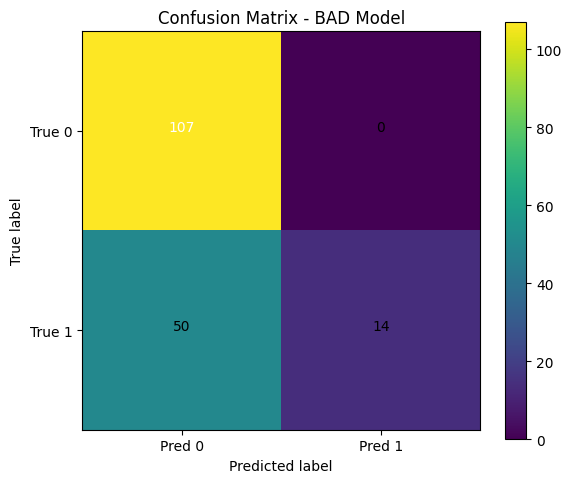

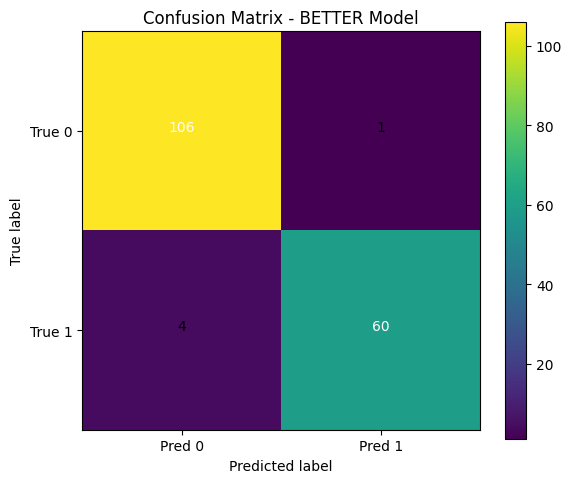

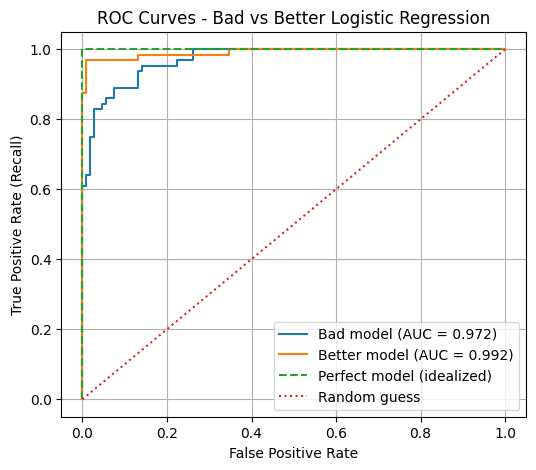

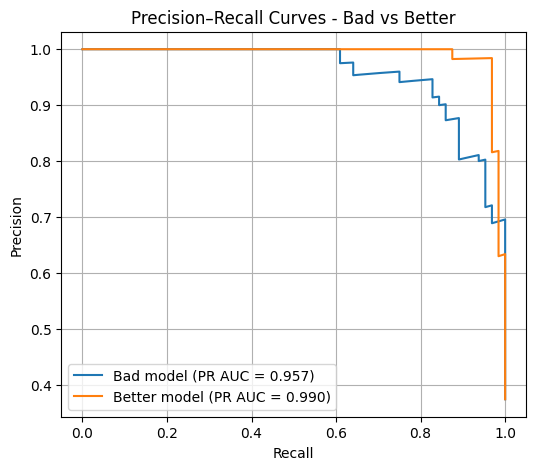


Threshold analysis for BAD model:
Thresh | Precision | Recall | F1
  0.30 |     0.838  |  0.891 |  0.864
  0.50 |     1.000  |  0.219 |  0.359
  0.70 |     1.000  |  0.016 |  0.031

Threshold analysis for BETTER model:
Thresh | Precision | Recall | F1
  0.30 |     0.984  |  0.953 |  0.968
  0.50 |     0.984  |  0.938 |  0.960
  0.70 |     0.983  |  0.906 |  0.943


In [2]:
# ==========================================
# 0. IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc
)

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6, 5)

# ==========================================
# 1. LOAD KAGGLE DATASET
# ==========================================
# Make sure 'data.csv' from:
# https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
# is uploaded in the same directory as this notebook.

df = pd.read_csv("data.csv")

print("Rows, Columns:", df.shape)
print(df.head())

# ==========================================
# 2. CLEAN + PREPARE DATA
# ==========================================
# Drop ID column (not a useful feature)
df = df.drop(columns=["id"])

# Drop empty column if present
df = df.drop(columns=["Unnamed: 32"], errors="ignore")

# Map labels: M = 1 (malignant), B = 0 (benign)
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# Train-test split (stratify keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ==========================================
# 3. SCALE FEATURES
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 4. BUILD INTENTIONALLY BAD MODEL
# ==========================================
# Bad decisions:
#  - Train on very few examples
#  - Very strong regularization (C=0.01)

X_train_tiny = X_train_scaled[:20]
y_train_tiny = y_train[:20]

bad_model = LogisticRegression(
    C=0.01,        # strong regularization -> underfitting
    max_iter=3000,
    random_state=42
)

bad_model.fit(X_train_tiny, y_train_tiny)

# Predictions and predicted probabilities
y_pred_bad = bad_model.predict(X_test_scaled)
y_proba_bad = bad_model.predict_proba(X_test_scaled)[:, 1]  # P(y=1)

precision_bad = precision_score(y_test, y_pred_bad)
recall_bad = recall_score(y_test, y_pred_bad)
f1_bad = f1_score(y_test, y_pred_bad)

print("\n================ BAD MODEL ==================")
print("Precision:", precision_bad)
print("Recall   :", recall_bad)
print("F1 Score :", f1_bad)
print("\nConfusion Matrix (bad):")
cm_bad = confusion_matrix(y_test, y_pred_bad)
print(cm_bad)
print("\nClassification Report (bad):")
print(classification_report(y_test, y_pred_bad))

# ==========================================
# 5. BUILD IMPROVED MODEL
# ==========================================
# Better decisions:
#  - Use ALL training data
#  - Weaker regularization (C=5.0)

better_model = LogisticRegression(
    C=5.0,
    max_iter=3000,
    random_state=42
)

better_model.fit(X_train_scaled, y_train)

y_pred_better = better_model.predict(X_test_scaled)
y_proba_better = better_model.predict_proba(X_test_scaled)[:, 1]

precision_better = precision_score(y_test, y_pred_better)
recall_better = recall_score(y_test, y_pred_better)
f1_better = f1_score(y_test, y_pred_better)

print("\n=============== BETTER MODEL =================")
print("Precision:", precision_better)
print("Recall   :", recall_better)
print("F1 Score :", f1_better)
print("\nConfusion Matrix (better):")
cm_better = confusion_matrix(y_test, y_pred_better)
print(cm_better)
print("\nClassification Report (better):")
print(classification_report(y_test, y_pred_better))

# ==========================================
# 6. SIDE-BY-SIDE METRIC COMPARISON
# ==========================================
print("\n=============== COMPARISON =================")
print(f"Precision: bad={precision_bad:.3f}, better={precision_better:.3f}")
print(f"Recall   : bad={recall_bad:.3f}, better={recall_better:.3f}")
print(f"F1-score : bad={f1_bad:.3f},  better={f1_better:.3f}")

# ==========================================
# 7. PLOT CONFUSION MATRICES (BAD vs BETTER)
# ==========================================
def plot_confusion_matrix(cm, title):
    tn, fp, fn, tp = cm.ravel()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0", "Pred 1"])
    plt.yticks(tick_marks, ["True 0", "True 1"])

    # Label the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm_bad, "Confusion Matrix - BAD Model")

plt.figure()
plot_confusion_matrix(cm_better, "Confusion Matrix - BETTER Model")

plt.show()

# ==========================================
# 8. ROC CURVES FOR BOTH MODELS
# ==========================================
# ROC: True Positive Rate vs False Positive Rate

fpr_bad, tpr_bad, _ = roc_curve(y_test, y_proba_bad)
fpr_better, tpr_better, _ = roc_curve(y_test, y_proba_better)

auc_bad = auc(fpr_bad, tpr_bad)
auc_better = auc(fpr_better, tpr_better)

plt.figure()
plt.plot(fpr_bad, tpr_bad, label=f"Bad model (AUC = {auc_bad:.3f})")
plt.plot(fpr_better, tpr_better, label=f"Better model (AUC = {auc_better:.3f})")
plt.plot([0, 0, 1], [0, 1, 1], linestyle="--", label="Perfect model (idealized)")
plt.plot([0, 1], [0, 1], linestyle=":", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves - Bad vs Better Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ==========================================
# 9. PRECISION–RECALL CURVES FOR BOTH MODELS
# ==========================================
prec_bad_curve, rec_bad_curve, _ = precision_recall_curve(y_test, y_proba_bad)
prec_better_curve, rec_better_curve, _ = precision_recall_curve(y_test, y_proba_better)

# AUC under PR curve (not always used, but helpful)
pr_auc_bad = auc(rec_bad_curve, prec_bad_curve)
pr_auc_better = auc(rec_better_curve, prec_better_curve)

plt.figure()
plt.plot(rec_bad_curve, prec_bad_curve, label=f"Bad model (PR AUC = {pr_auc_bad:.3f})")
plt.plot(rec_better_curve, prec_better_curve, label=f"Better model (PR AUC = {pr_auc_better:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - Bad vs Better")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ==========================================
# 10. THRESHOLD TUNING: PRECISION/RECALL AT VARIOUS THRESHOLDS
# ==========================================
def evaluate_at_thresholds(y_true, y_proba, thresholds, model_name):
    print(f"\nThreshold analysis for {model_name}:")
    print("Thresh | Precision | Recall | F1")
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        p = precision_score(y_true, y_pred_thr, zero_division=0)
        r = recall_score(y_true, y_pred_thr, zero_division=0)
        f1 = f1_score(y_true, y_pred_thr, zero_division=0)
        print(f"{thr:6.2f} |   {p:7.3f}  | {r:6.3f} | {f1:6.3f}")

thresholds = [0.3, 0.5, 0.7]

evaluate_at_thresholds(y_test, y_proba_bad, thresholds, "BAD model")
evaluate_at_thresholds(y_test, y_proba_better, thresholds, "BETTER model")
